In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib.patches import Patch

## 1. Data Preparation

In [5]:
# Load the data
df = pd.read_csv('../data/cost_of_living_us.csv')
df.head()

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31430 entries, 0 to 31429
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   case_id                 31430 non-null  int64  
 1   state                   31430 non-null  object 
 2   isMetro                 31430 non-null  bool   
 3   areaname                31430 non-null  object 
 4   county                  31430 non-null  object 
 5   family_member_count     31430 non-null  object 
 6   housing_cost            31430 non-null  float64
 7   food_cost               31430 non-null  float64
 8   transportation_cost     31430 non-null  float64
 9   healthcare_cost         31430 non-null  float64
 10  other_necessities_cost  31430 non-null  float64
 11  childcare_cost          31430 non-null  float64
 12  taxes                   31430 non-null  float64
 13  total_cost              31430 non-null  float64
 14  median_family_income    31420 non-null

## 2. Data Cleaning

In [7]:
#Check if there is any missing value
df.isnull().sum()

case_id                    0
state                      0
isMetro                    0
areaname                   0
county                     0
family_member_count        0
housing_cost               0
food_cost                  0
transportation_cost        0
healthcare_cost            0
other_necessities_cost     0
childcare_cost             0
taxes                      0
total_cost                 0
median_family_income      10
dtype: int64

In [8]:
#Fill NaN values of median_family_income with the mean of median_family_income based on state, isMetro and area
df['median_family_income'] = df.groupby(['state','isMetro','areaname'])['median_family_income'].transform(lambda x: x.fillna(x.mean()))
# Create an affordability metric (total_cost as % of median income)
df['affordability'] = (df['total_cost'] / df['median_family_income']) * 100

print('Unique states:', df['state'].unique())
print('Number of counties:', df['county'].nunique())
print('Metro vs non-metro distribution:', df['isMetro'].map({True: 'Metro', False: 'Non-Metro'}).value_counts())

Unique states: ['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
Number of counties: 1877
Metro vs non-metro distribution: isMetro
Non-Metro    19730
Metro        11700
Name: count, dtype: int64


## 3. Regional Variation Analysis
### 3.1 State Level Analysis

In [9]:
#Group by state and calculate averages
state_stats = df.groupby('state').agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'   
})
#Sort by total cost
state_stats_cost = state_stats.sort_values(('total_cost'))
print("The Average Total Cost by States:\n")
print(state_stats_cost.head())
#Sort by affordability
state_stats_affordability = state_stats.sort_values(('affordability'))
print("\nThe Affordability by States:\n")
print(state_stats_affordability.head())

The Average Total Cost by States:

         total_cost  median_family_income  affordability
state                                                   
MS     61360.990604          52281.524319     121.888989
AR     61491.891851          55025.567812     113.348998
SC     62104.869806          60021.241338     105.692082
TN     62871.107261          59715.511924     107.282295
TX     64795.398352          66050.294268     101.690525

The Affordability by States:

         total_cost  median_family_income  affordability
state                                                   
RI     83512.769736         101153.248438      83.538656
ND     68709.927609          82881.291421      84.937101
NH     74802.494172          89199.250000      84.950401
MD     79001.490465          96138.127604      85.043449
CT     90013.504620         103228.233398      87.683411


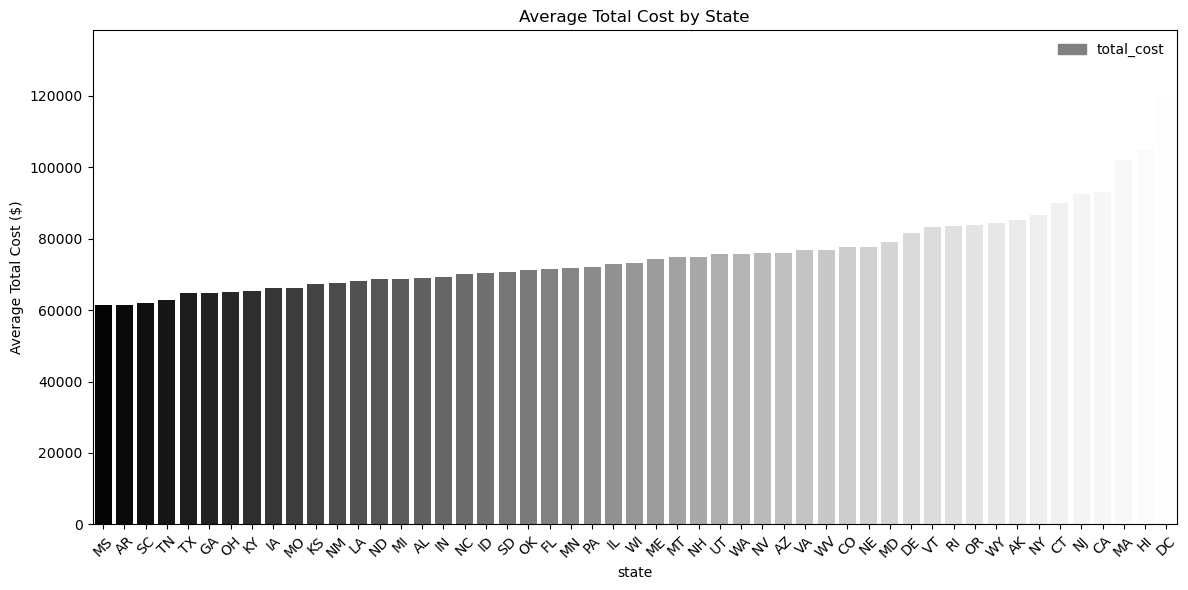

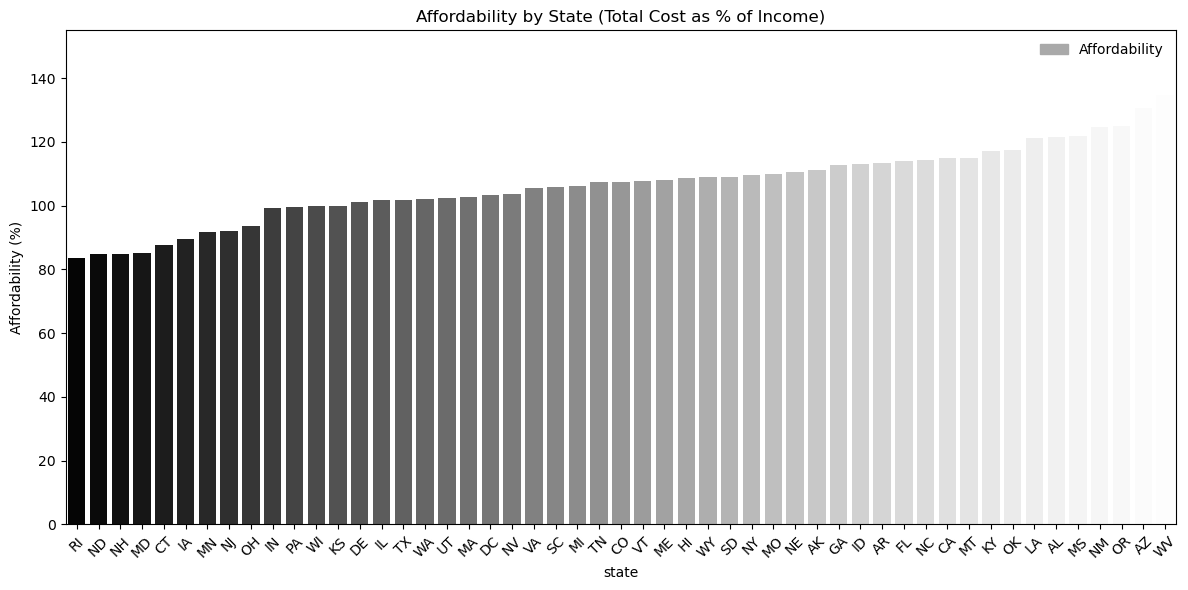

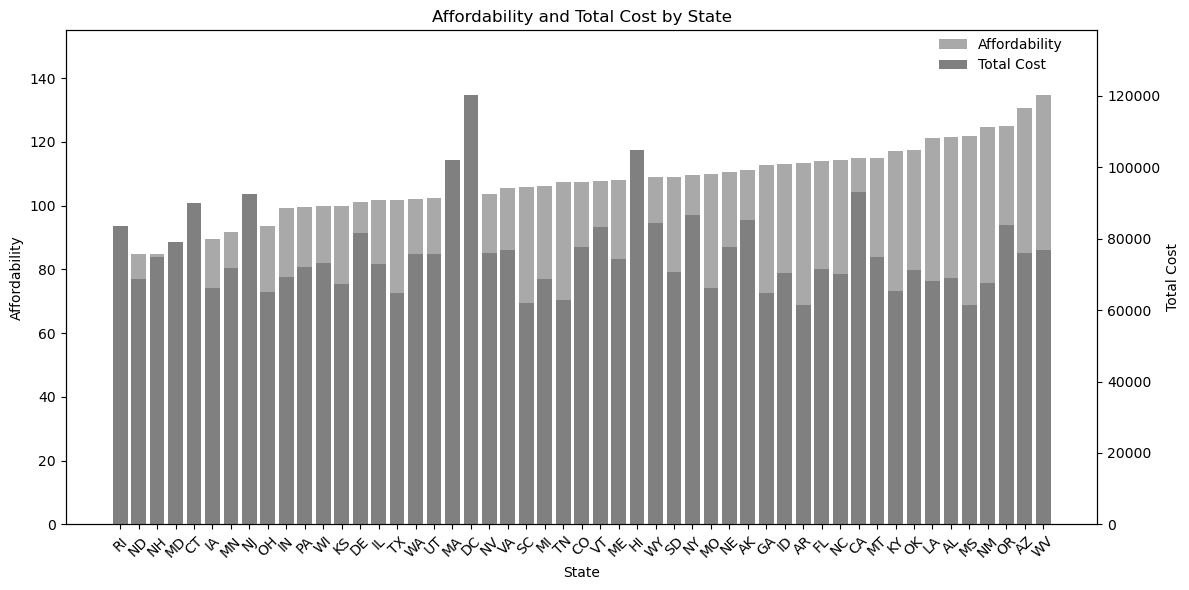

In [10]:
# Plotting the average total cost by state
# Adjusting the y-limits to add space
max_affordability_state = state_stats_cost['affordability'].max()  
max_total_cost_state = state_stats_affordability['total_cost'].max()  
# Adding space (margin) to the max values of both y-axes by 20%
affordability_margin_state = 0.15 * max_affordability_state  
total_cost_margin_state = 0.15 * max_total_cost_state  

plt.figure(figsize=(12, 6))
sns.barplot(x=state_stats_cost.index, y=state_stats_cost['total_cost'], hue=state_stats_cost.index, palette='Greys_r')
plt.title('Average Total Cost by State')
plt.xticks(rotation=45)
plt.ylabel('Average Total Cost ($)')
# Create a custom legend handle to match the bar color (using Patch)
cost_legend = [Patch(color='grey', label='total_cost')]
# Add custom legend
plt.legend(handles=cost_legend, loc='upper right', frameon=False)
plt.ylim(0, max_total_cost_state + total_cost_margin_state)
plt.tight_layout()
plt.show()

# Plotting the affordability by state
plt.figure(figsize=(12, 6))
sns.barplot(x=state_stats_affordability.index, y=state_stats_affordability['affordability'], hue=state_stats_affordability.index, palette='Greys_r')
plt.title('Affordability by State (Total Cost as % of Income)')
plt.xticks(rotation=45)
plt.ylabel('Affordability (%)')
# Create a custom legend handle to match the bar color (using Patch)
affordability_legend = [Patch(color='darkgrey', label='Affordability')]
# Add custom legend
plt.legend(handles=affordability_legend, loc='upper right', frameon=False)
plt.ylim(0, max_affordability_state + affordability_margin_state)
plt.tight_layout()
plt.show()

# Plotting state-level affordability vs the average of the total cost
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plotting affordability on the first axis
affordability_bars = ax1.bar(state_stats_affordability.index, state_stats_affordability['affordability'], label='Affordability', 
                             color='darkgrey', align='center')
ax1.set_ylabel('Affordability')
ax1.set_xlabel('State')
# Plotting a second y-axis for total_cost
ax2 = ax1.twinx()
total_cost_bars = ax2.bar([i for i in range(len(state_stats_affordability))], state_stats_affordability['total_cost'],label='Total Cost', 
                          color='grey', align='center')
ax2.set_ylabel('Total Cost')
# Add title and labels
plt.title('Affordability and Total Cost by State')
ax1.set_xticks(range(len(state_stats_affordability)))
ax1.set_xticklabels(state_stats_affordability.index, rotation=45)
# Combine the legends for both axes into a single legend in the top-right
handles, labels = [], []
# Get the handles and labels for both bars
handles.extend([affordability_bars, total_cost_bars])
labels.extend(['Affordability', 'Total Cost'])
# Add a single legend to the plot in the top-right corner
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.95), frameon=False)
ax1.set_ylim(0, max_affordability_state + affordability_margin_state)
ax2.set_ylim(0, max_total_cost_state + total_cost_margin_state)
plt.tight_layout()
plt.show()

### 3.2 Metro vs Non-Metro Analysis

In [11]:
# Compare metro vs non-metro areas
metro_stats = df.groupby('isMetro').agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'
})
print("The Total Cost and Affordability by Metro:\n")
print(metro_stats.head())

The Total Cost and Affordability by Metro:

           total_cost  median_family_income  affordability
isMetro                                                   
False    67588.016584          62826.026868     110.972323
True     76489.602427          77582.631931     101.436268


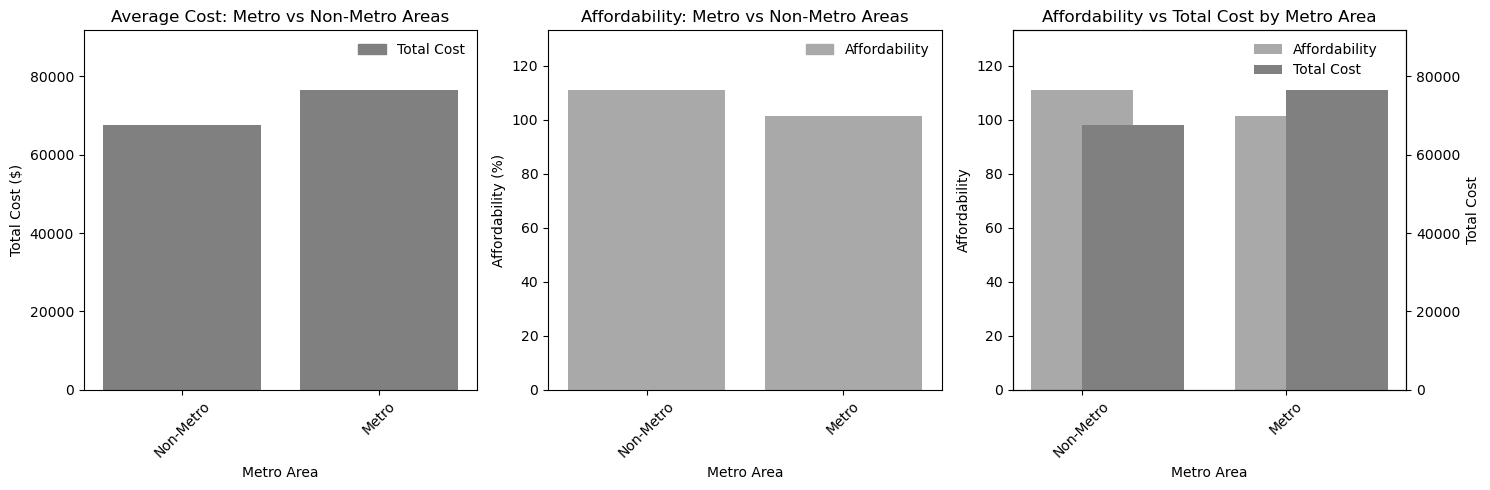

In [12]:
# Adjusting the y-limits to add space
max_affordability = metro_stats['affordability'].max()  
max_total_cost = metro_stats['total_cost'].max()  
# Adding space (margin) to the max values of both y-axes by 20%
affordability_margin = 0.2 * max_affordability  
total_cost_margin = 0.2 * max_total_cost  
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the average total cost by metro area
sns.barplot(x='isMetro', y='total_cost', data=metro_stats,color='grey', ax=axes[0])
axes[0].set_title('Average Cost: Metro vs Non-Metro Areas')
axes[0].set_xlabel('Metro Area')
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Metro', 'Metro'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
cost_legend = [Patch(color='grey', label='Total Cost')]
axes[0].legend(handles=cost_legend, loc='upper right', frameon=False)
axes[0].set_ylim(0, max_total_cost + total_cost_margin) 

# Plotting the affordability by metro area
sns.barplot(x='isMetro', y='affordability', data=metro_stats,color='darkgrey', ax=axes[1])
axes[1].set_title('Affordability: Metro vs Non-Metro Areas')
axes[1].set_xlabel('Metro Area')
axes[1].set_ylabel('Affordability (%)')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Metro', 'Metro'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
affordability_legend = [Patch(color='darkgrey', label='Affordability')]
axes[1].legend(handles=affordability_legend, loc='upper right', frameon=False)
axes[1].set_ylim(0, max_affordability + affordability_margin)

# Plotting the affordability vs the average of total cost by metro area
width = 0.5
affordability_bars = axes[2].bar(metro_stats.index, metro_stats['affordability'], width=width, label='Affordability', color='darkgrey', align='center')
axes[2].set_ylabel('Affordability')
axes[2].set_xlabel('Metro Area')
# Plotting a second y-axis for total_cost
ax2 = axes[2].twinx()
total_cost_bars = ax2.bar([i for i in range(len(metro_stats))], metro_stats['total_cost'], width=width, label='Total Cost', color='grey', align='edge')
ax2.set_ylabel('Total Cost')

plt.title('Affordability vs Total Cost by Metro Area')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Non-Metro', 'Metro'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
handles, labels = [], []
handles.extend([affordability_bars, total_cost_bars])
labels.extend(['Affordability', 'Total Cost'])
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.93, 0.93), frameon=False)
axes[2].set_ylim(0, max_affordability + affordability_margin)
ax2.set_ylim(0, max_total_cost + total_cost_margin)
plt.tight_layout()
plt.show()

### 3.3 Country-Level Analysis

In [13]:
# Get the total cost, median family income and affordability by state and county
county_stats = df.groupby(['state', 'county']).agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'
})
# Get the top 10 most expensive counties
most_expensive_county = county_stats.sort_values('total_cost', ascending=False).head(10)
# Get the top 10 least expensive counties
least_expensive_county = county_stats.sort_values('total_cost').head(10)
# Get the top 10 least affordability counties
least_affordable_county = county_stats.sort_values('affordability', ascending=False).head(10)
# Get the top 10 most affordability counties
most_affordable_county = county_stats.sort_values('affordability').head(10)
# Merg multi-index as a single one
most_expensive_county.index = most_expensive_county.index.map(lambda x: f"{x[0]} - {x[1]}")
least_expensive_county.index = least_expensive_county.index.map(lambda x: f"{x[0]} - {x[1]}")
least_affordable_county.index = least_affordable_county.index.map(lambda x: f"{x[0]} - {x[1]}")
most_affordable_county.index = most_affordable_county.index.map(lambda x: f"{x[0]} - {x[1]}")
print("The Top 10 Most Expensive Counties:\n")
print(most_expensive_county)
print("\nThe Top 10 Least Affordable Counties:\n")
print(least_affordable_county)
print("\nThe Top 10 Least Expensive Counties:\n")
print(least_expensive_county)
print("\nThe Top 10 Most Affordable Counties:\n")
print(most_affordable_county)

The Top 10 Most Expensive Counties:

                             total_cost  median_family_income  affordability
CA - San Mateo County      167022.47100         145687.109375     114.644646
CA - Marin County          157044.03180         157777.984375      99.534819
CA - San Francisco County  142391.32356         135125.171875     105.377349
NY - New York County       137874.70452         112986.804688     122.027262
CA - Santa Cruz County     137829.51408         105463.250000     130.689614
CA - Santa Clara County    133914.75216         144424.109375      92.723267
NY - Putnam County         130231.34316         125987.445312     103.368509
NY - Rockland County       127029.12732         113247.617188     112.169360
NY - Nassau County         126531.71112         139281.765625      90.845855
MA - Norfolk County        126195.66564         132538.593750      95.214278

The Top 10 Least Affordable Counties:

                             total_cost  median_family_income  affordability

#### 3.3.1 Top 10 Least Affordability vs Total Cost by County

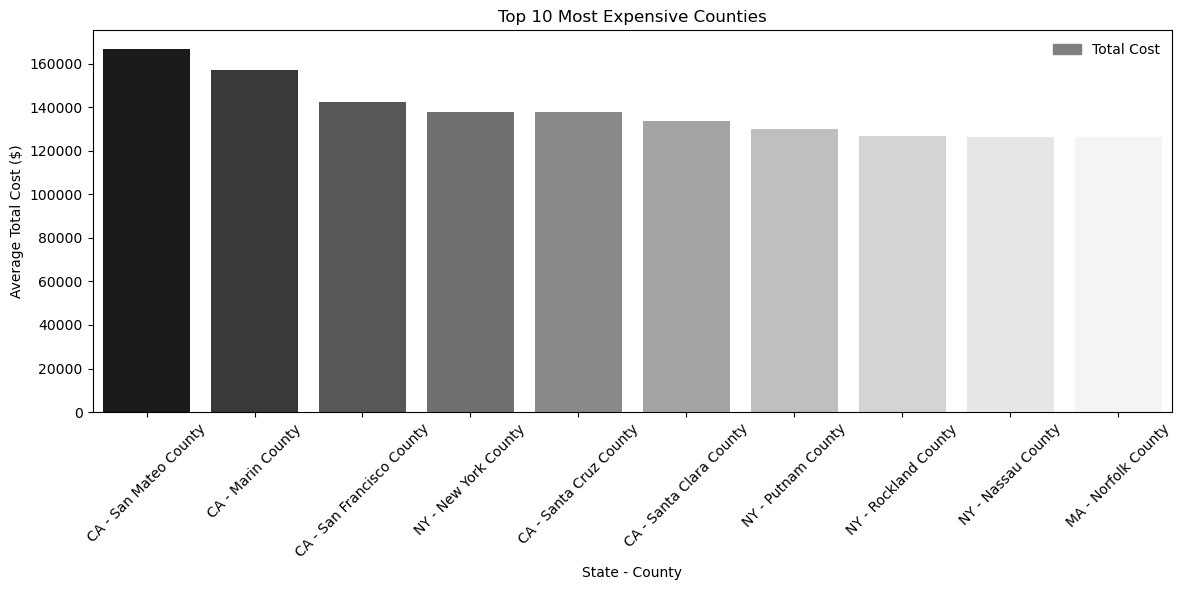

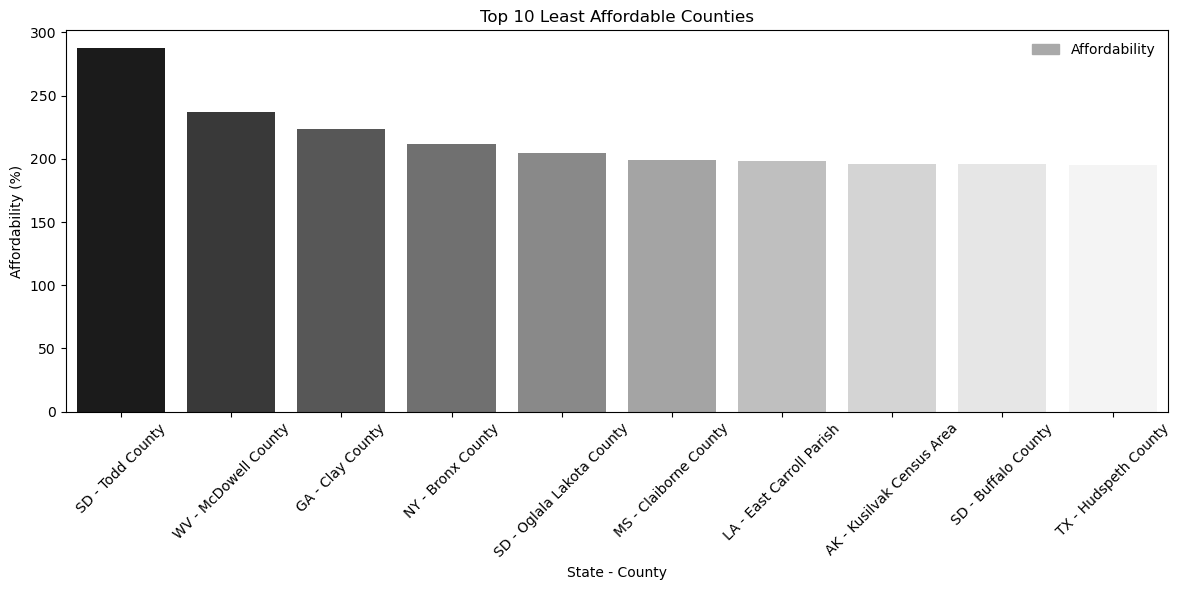

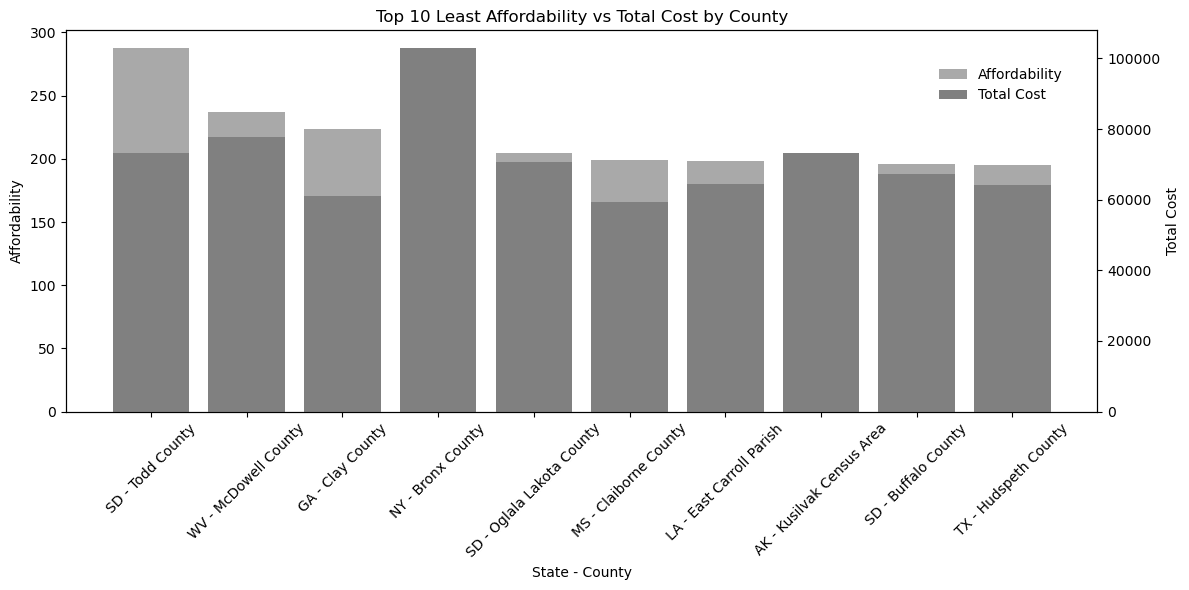

In [14]:
# Plotting the top 10 most expensive counties
plt.figure(figsize=(12, 6))
sns.barplot(x=most_expensive_county.index, y=most_expensive_county['total_cost'], hue=most_expensive_county.index, palette='Greys_r')
plt.title('Top 10 Most Expensive Counties')
plt.xlabel('State - County')
plt.xticks(rotation=45)
plt.ylabel('Average Total Cost ($)')
# Create a custom legend handle to match the bar color (using Patch)
high_cost_legend = [Patch(color='grey', label='Total Cost')]
# Add custom legend
plt.legend(handles=high_cost_legend, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

# Plotting the top 10 least affordable counties
plt.figure(figsize=(12, 6))
sns.barplot(x=least_affordable_county.index, y=least_affordable_county['affordability'], hue=least_affordable_county.index, palette='Greys_r')
plt.title('Top 10 Least Affordable Counties')
plt.xlabel('State - County')
plt.xticks(rotation=45)
plt.ylabel('Affordability (%)')
# Create a custom legend handle to match the bar color (using Patch)
least_affordability_legend = [Patch(color='darkgrey', label='Affordability')]
# Add custom legend
plt.legend(handles=least_affordability_legend, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

# Plotting county-level least affordability vs the average of the total cost
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plotting affordability on the first axis
least_affordability_bars = ax1.bar(least_affordable_county.index, least_affordable_county['affordability'], label='Affordability', 
                                   color='darkgrey', align='center')
ax1.set_ylabel('Affordability')
ax1.set_xlabel('State - County')
# Plotting a second y-axis for total_cost
ax2 = ax1.twinx()
highest_total_cost_bars = ax2.bar([i for i in range(len(least_affordable_county))], least_affordable_county['total_cost'],label='Total Cost', 
                                  color='grey', align='center')
ax2.set_ylabel('Total Cost')
# Add title and labels
plt.title('Top 10 Least Affordability vs Total Cost by County')
ax1.set_xticks(range(len(least_affordable_county)))
ax1.set_xticklabels(least_affordable_county.index, rotation=45)
# Combine the legends for both axes into a single legend in the top-right
handles1, labels1 = [], []
# Get the handles and labels for both bars
handles1.extend([least_affordability_bars, highest_total_cost_bars])
labels1.extend(['Affordability', 'Total Cost'])
# Add a single legend to the plot in the top-right corner
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=False)
plt.tight_layout()
plt.show()

#### 3.3.2 Top 10 Most Affordability vs Total Cost by County

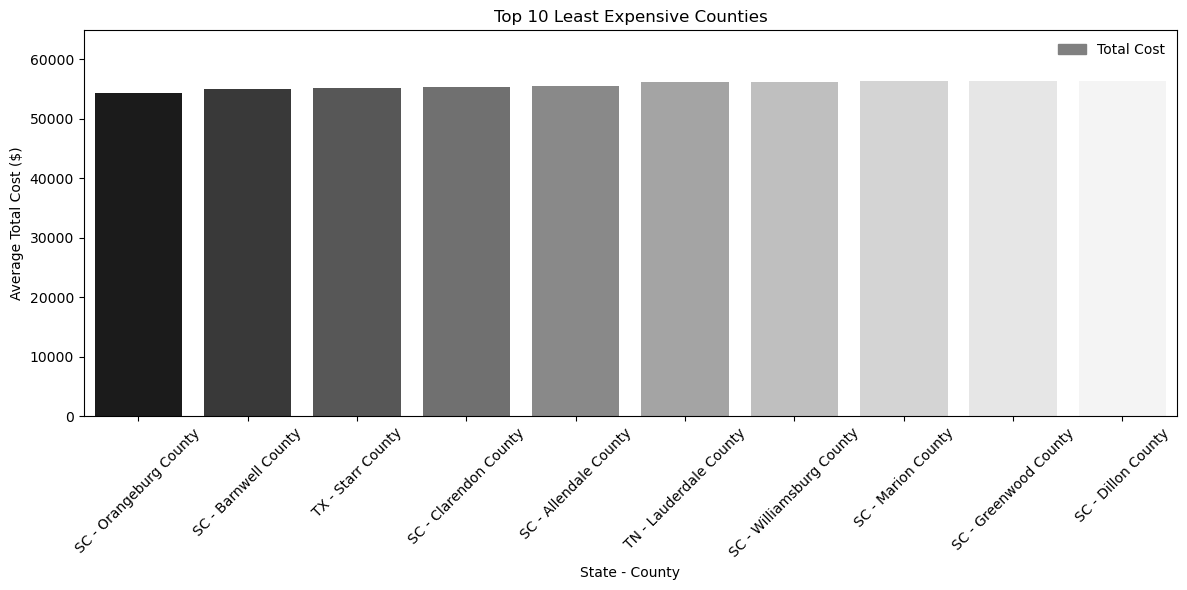

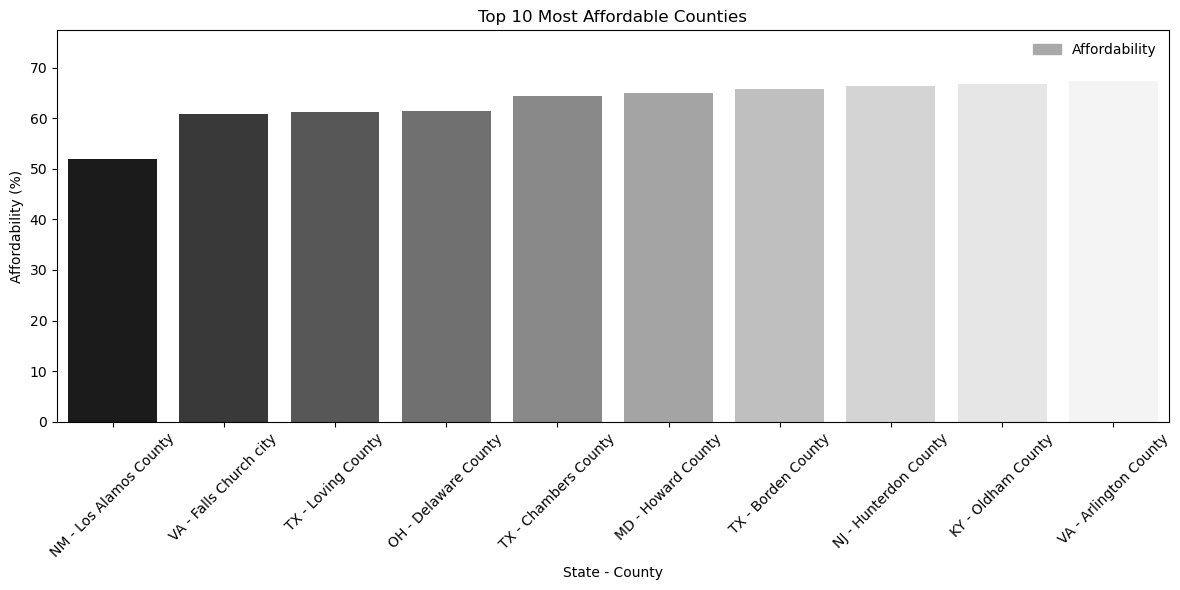

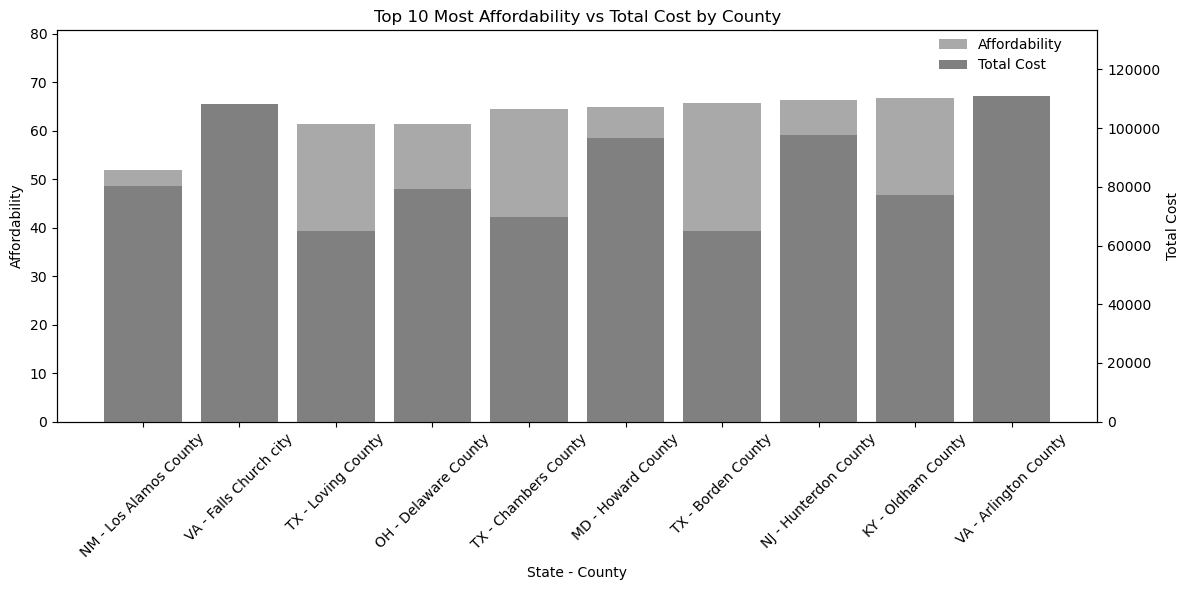

In [15]:
# Plotting the top 10 least expensive counties
#least_expensive_county.index = least_expensive_county.index.map(lambda x: f"{x[0]} - {x[1]}")
plt.figure(figsize=(12, 6))
sns.barplot(x=least_expensive_county.index, y=least_expensive_county['total_cost'], hue=least_expensive_county.index, palette='Greys_r')
plt.title('Top 10 Least Expensive Counties')
plt.xlabel('State - County')
plt.xticks(rotation=45)
plt.ylabel('Average Total Cost ($)')
# Create a custom legend handle to match the bar color (using Patch)
low_cost_legend = [Patch(color='grey', label='Total Cost')]
# Add custom legend
plt.legend(handles=low_cost_legend, loc='upper right', frameon=False)
plt.ylim(0, least_expensive_county['total_cost'].max() * 1.15) 
plt.tight_layout()
plt.show()

# Plotting the top 10 Most affordable counties
plt.figure(figsize=(12, 6))
sns.barplot(x=most_affordable_county.index, y=most_affordable_county['affordability'], hue=most_affordable_county.index, palette='Greys_r')
plt.title('Top 10 Most Affordable Counties')
plt.xlabel('State - County')
plt.xticks(rotation=45)
plt.ylabel('Affordability (%)')
# Create a custom legend handle to match the bar color (using Patch)
most_affordability_legend = [Patch(color='darkgrey', label='Affordability')]
# Add custom legend
plt.legend(handles=most_affordability_legend, loc='upper right', frameon=False)
plt.ylim(0, most_affordable_county['affordability'].max() * 1.15) 
plt.tight_layout()
plt.show()

# Plotting county-level most affordability vs the average of the total cost
# Adjusting the y-limits to add space
max_affordability_county = most_affordable_county['affordability'].max()  
max_total_cost_county = most_affordable_county['total_cost'].max()  
# Adding space (margin) to the max values of both y-axes by 20%
affordability_margin_county = 0.2 * max_affordability_county  
total_cost_margin_county = 0.2 * max_total_cost_county  

fig, ax3 = plt.subplots(figsize=(12, 6))
# Plotting affordability on the first axis
most_affordability_bars = ax3.bar(most_affordable_county.index, most_affordable_county['affordability'],label='Affordability', 
                                  color='darkgrey', align='center')
ax3.set_ylabel('Affordability')
ax3.set_xlabel('State - County')
# Plotting a second y-axis for total_cost
ax4 = ax3.twinx()
least_total_cost_bars = ax4.bar([i for i in range(len(most_affordable_county))], most_affordable_county['total_cost'],label='Total Cost', 
                                color='grey', align='center')
ax4.set_ylabel('Total Cost')
# Add title and labels
plt.title('Top 10 Most Affordability vs Total Cost by County')
ax3.set_xticks(range(len(most_affordable_county)))
ax3.set_xticklabels(most_affordable_county.index, rotation=45)
# Combine the legends for both axes into a single legend in the top-right
handles2, labels2 = [], []
# Get the handles and labels for both bars
handles2.extend([most_affordability_bars, least_total_cost_bars])
labels2.extend(['Affordability', 'Total Cost'])
# Add a single legend to the plot in the top-right corner
fig.legend(handles2, labels2, loc='upper right', bbox_to_anchor=(0.9, 0.95), frameon=False)
ax3.set_ylim(0, max_affordability_county + affordability_margin_county)
ax4.set_ylim(0, max_total_cost_county + total_cost_margin_county)
plt.tight_layout()
plt.show()

### 3.4 Geographic Area Analysis

In [16]:
# Since we don't have exact coordinates, we can look at area names
# Extract MSA (Metropolitan Statistical Area) information
df['MSA'] = df['areaname'].str.extract(r'^(.*?)(?: MSA|,|$)', expand=False)

# Analyze by MSA
msa_stats = df.groupby(['state', 'MSA']).agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'
})

least_affordabilty_msa = msa_stats.sort_values('affordability', ascending=False).head(10)
most_affordabilty_msa = msa_stats.sort_values('affordability').head(10)
most_expensive_msa = msa_stats.sort_values('total_cost', ascending=False).head(10)
least_expensive_msa = msa_stats.sort_values('total_cost').head(10)

# Merg multi-index as a single one
most_expensive_msa.index = most_expensive_msa.index.map(lambda x: f"{x[0]} - {x[1]}")
least_expensive_msa.index = least_expensive_msa.index.map(lambda x: f"{x[0]} - {x[1]}")
least_affordabilty_msa.index = least_affordabilty_msa.index.map(lambda x: f"{x[0]} - {x[1]}")
most_affordabilty_msa.index = most_affordabilty_msa.index.map(lambda x: f"{x[0]} - {x[1]}")

print("The Top 10 Most Expensive MSA Areas:\n")
print(most_expensive_msa)
print("\nThe Top 10 Least Affordable MSA Areas:\n")
print(least_affordabilty_msa)
print("\nThe Top 10 Least Expensive MSA Areas:\n")
print(least_expensive_msa)
print("\nThe Top 10 Most Affordable MSA Areas:\n")
print(most_affordabilty_msa)

The Top 10 Most Expensive MSA Areas:

                                         total_cost  median_family_income  \
CA - San Francisco                    155485.942120         146196.755208   
CA - Santa Cruz-Watsonville           137829.514080         105463.250000   
CA - San Jose-Sunnyvale-Santa Clara   133914.752160         144424.109375   
NY - Nassau-Suffolk                   126074.585220         130564.011719   
NY - Westchester County               122778.320760         128014.406250   
NY - New York                         122290.969629          93314.871094   
DC - Washington-Arlington-Alexandria  120289.636920         116607.390625   
CA - Oakland-Fremont                  118227.599700         120214.121094   
CA - Santa Maria-Santa Barbara        116973.297960          87471.203125   
HI - Urban Honolulu                   116321.461920         103898.367188   

                                      affordability  
CA - San Francisco                       106.518938  
CA - S

#### 3.4.1 Top 10 Least Affordability vs Total Cost by Area

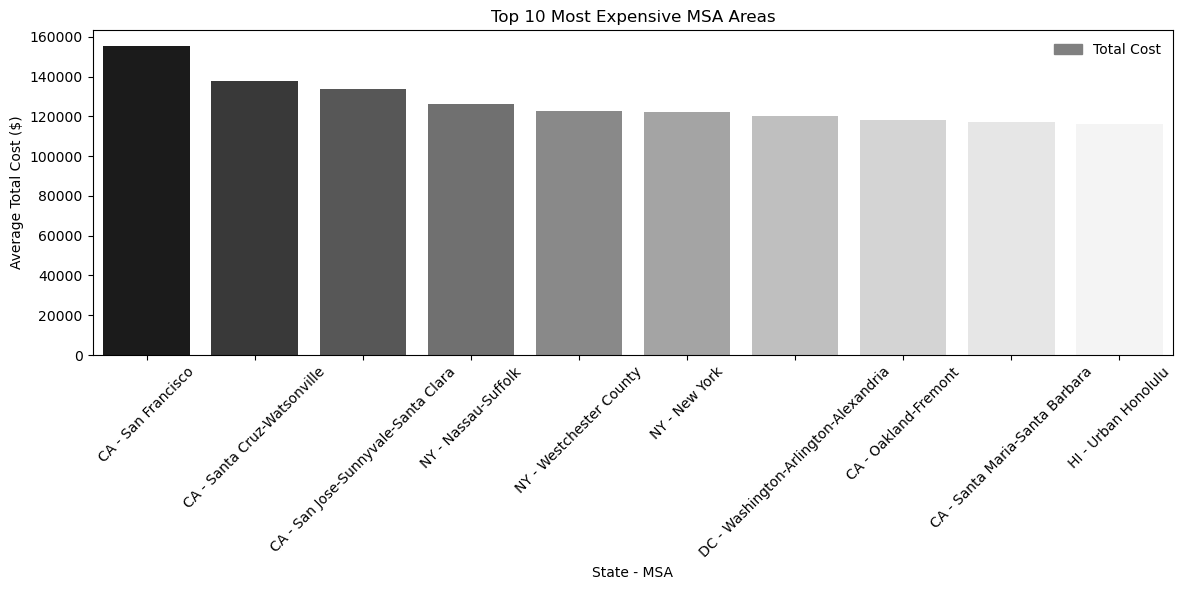

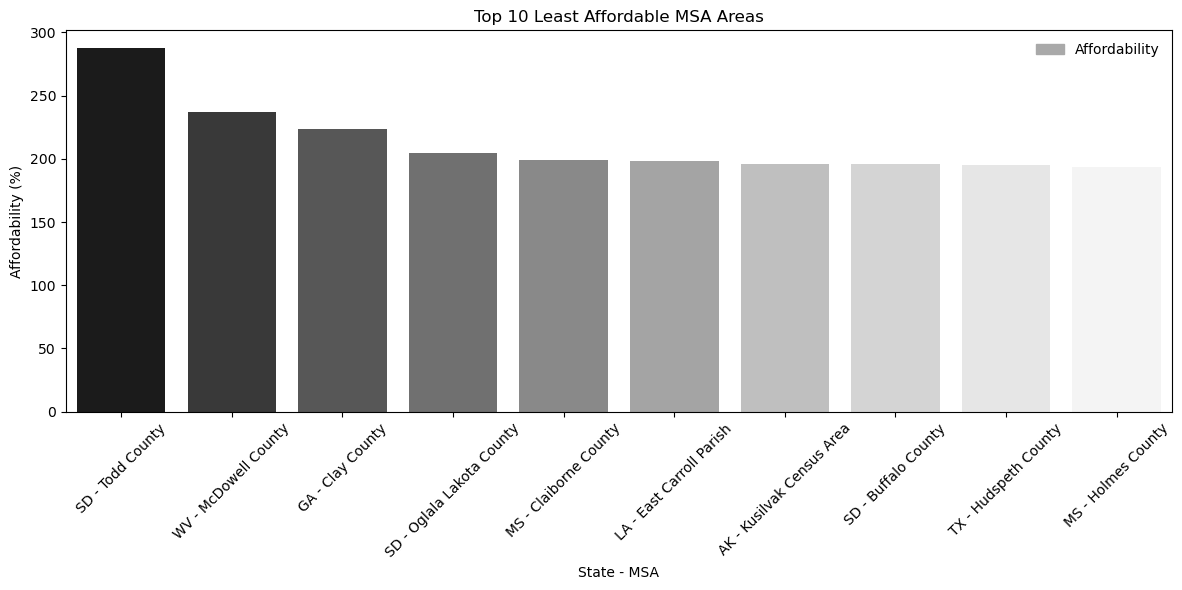

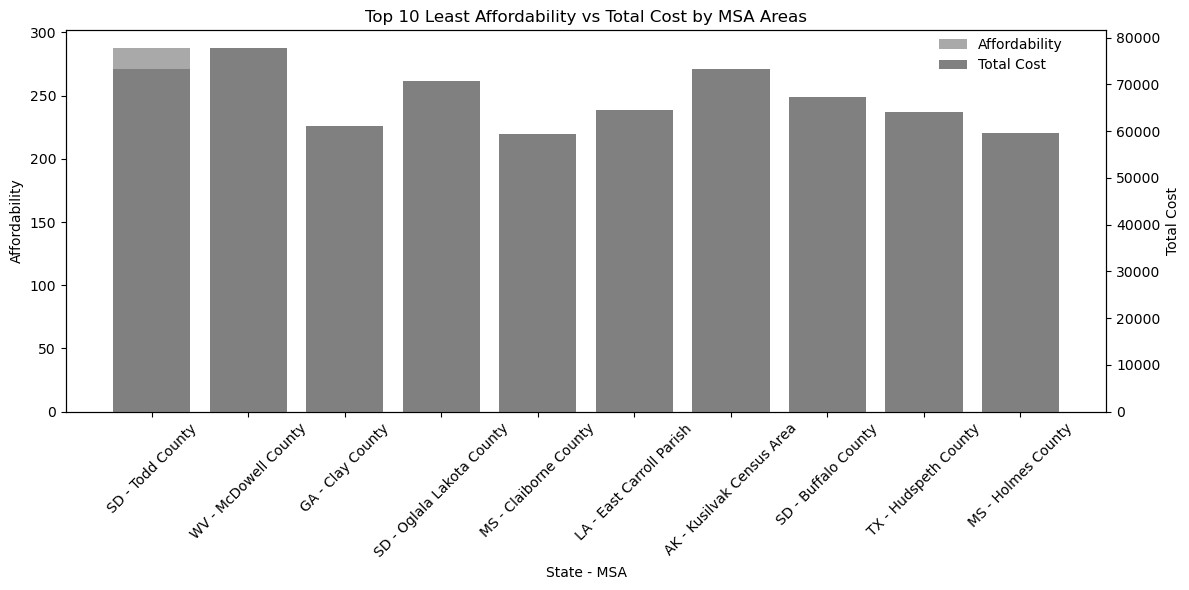

In [17]:
# Plotting the top 10 most expensive MSA areas
plt.figure(figsize=(12, 6))
sns.barplot(x=most_expensive_msa.index, y=most_expensive_msa['total_cost'], hue=most_expensive_msa.index, palette='Greys_r')
plt.title('Top 10 Most Expensive MSA Areas')
plt.xlabel('State - MSA')
plt.xticks(rotation=45)
plt.ylabel('Average Total Cost ($)')
# Create a custom legend handle to match the bar color (using Patch)
high_cost_legend = [Patch(color='grey', label='Total Cost')]
# Add custom legend
plt.legend(handles=high_cost_legend, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

# Plotting the top 10 least affordable MSA areas
plt.figure(figsize=(12, 6))
sns.barplot(x=least_affordabilty_msa.index, y=least_affordabilty_msa['affordability'], hue=least_affordabilty_msa.index, palette='Greys_r')
plt.title('Top 10 Least Affordable MSA Areas')
plt.xlabel('State - MSA')
plt.xticks(rotation=45)
plt.ylabel('Affordability (%)')
# Create a custom legend handle to match the bar color (using Patch)
least_affordability_legend = [Patch(color='darkgrey', label='Affordability')]
# Add custom legend
plt.legend(handles=least_affordability_legend, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

# Plotting area-level least affordability vs the average of the total cost
fig, ax5 = plt.subplots(figsize=(12, 6))
# Plotting affordability on the first axis
least_affordability_bars_msa = ax5.bar(least_affordabilty_msa.index, least_affordabilty_msa['affordability'], label='Affordability', 
                                       color='darkgrey', align='center')
ax5.set_ylabel('Affordability')
ax5.set_xlabel('State - MSA')
# Plotting a second y-axis for total_cost
ax6 = ax5.twinx()
highest_total_cost_bars_msa = ax6.bar([i for i in range(len(least_affordabilty_msa))], least_affordabilty_msa['total_cost'],label='Total Cost', 
                                      color='grey', align='center')
ax6.set_ylabel('Total Cost')
# Add title and labels
plt.title('Top 10 Least Affordability vs Total Cost by MSA Areas')
ax5.set_xticks(range(len(least_affordabilty_msa)))
ax5.set_xticklabels(least_affordabilty_msa.index, rotation=45)
# Combine the legends for both axes into a single legend in the top-right
handles_msa, labels_msa = [], []
# Get the handles and labels for both bars
handles_msa.extend([least_affordability_bars_msa, highest_total_cost_bars_msa])
labels_msa.extend(['Affordability', 'Total Cost'])
# Add a single legend to the plot in the top-right corner
fig.legend(handles_msa, labels_msa, loc='upper right', bbox_to_anchor=(0.9, 0.95), frameon=False)
plt.tight_layout()
plt.show()

#### 3.4.2 Top 10 Most Affordability vs Total Cost by Area

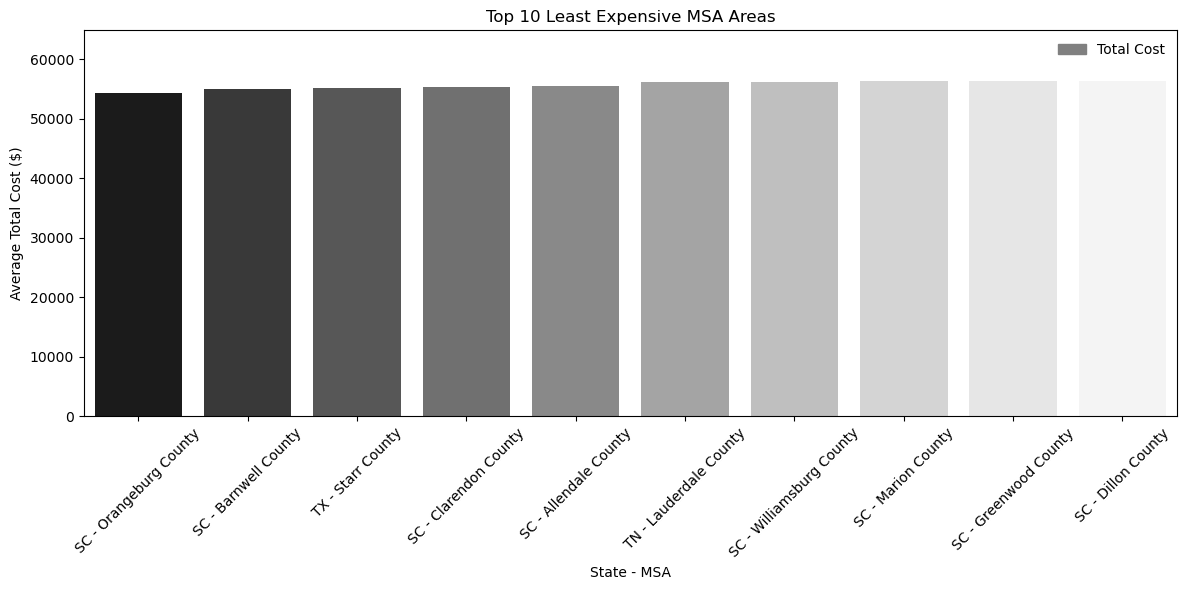

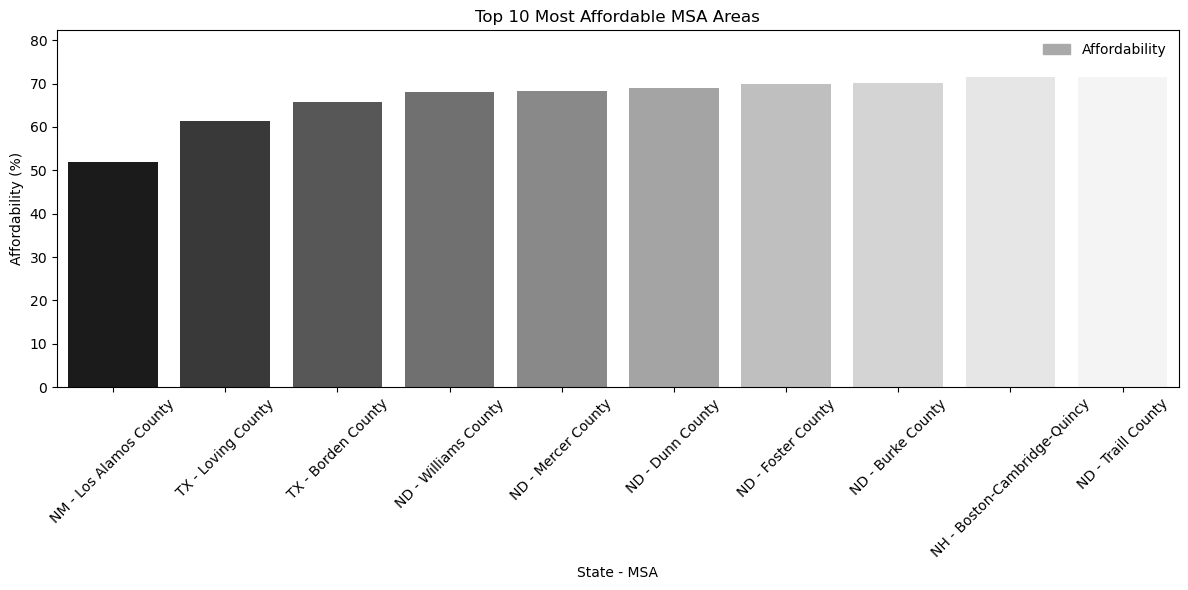

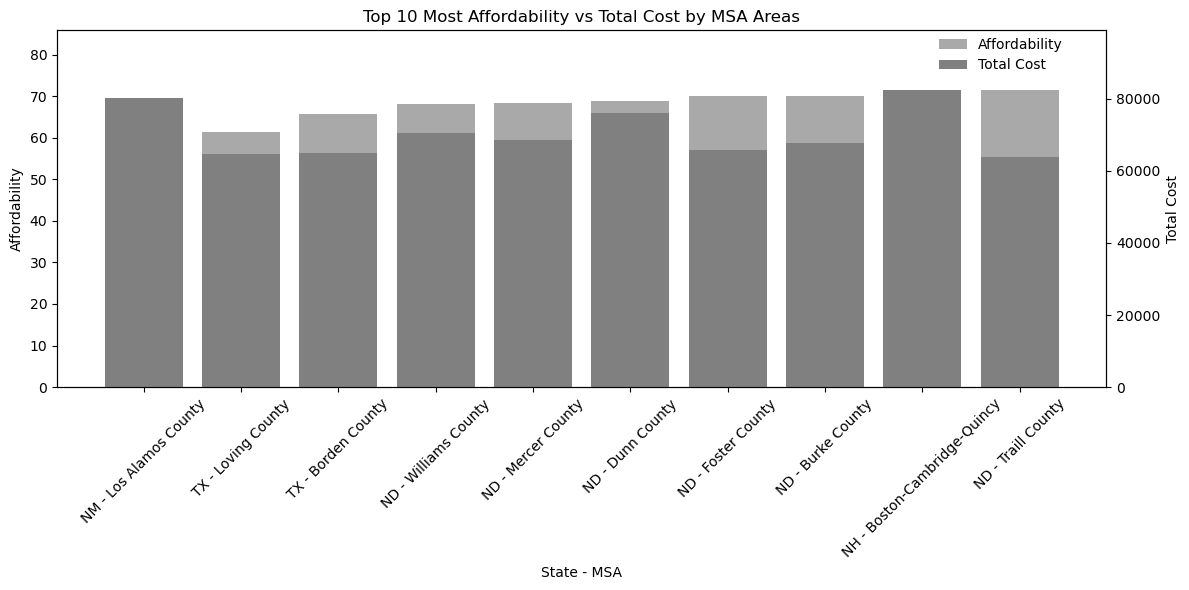

In [18]:
# Plotting the top 10 least expensive MSA areas
plt.figure(figsize=(12, 6))
sns.barplot(x=least_expensive_msa.index, y=least_expensive_msa['total_cost'], hue=least_expensive_msa.index, palette='Greys_r')
plt.title('Top 10 Least Expensive MSA Areas')
plt.xlabel('State - MSA')
plt.xticks(rotation=45)
plt.ylabel('Average Total Cost ($)')
# Create a custom legend handle to match the bar color (using Patch)
low_cost_legend = [Patch(color='grey', label='Total Cost')]
# Add custom legend
plt.legend(handles=low_cost_legend, loc='upper right', frameon=False)
plt.ylim(0, least_expensive_msa['total_cost'].max() * 1.15) 
plt.tight_layout()
plt.show()

# Plotting the top 10 Most affordable MSA areas
plt.figure(figsize=(12, 6))
sns.barplot(x=most_affordabilty_msa.index, y=most_affordabilty_msa['affordability'], hue=most_affordabilty_msa.index, palette='Greys_r')
plt.title('Top 10 Most Affordable MSA Areas')
plt.xlabel('State - MSA')
plt.xticks(rotation=45)
plt.ylabel('Affordability (%)')
# Create a custom legend handle to match the bar color (using Patch)
most_affordability_legend = [Patch(color='darkgrey', label='Affordability')]
# Add custom legend
plt.legend(handles=most_affordability_legend, loc='upper right', frameon=False)
plt.ylim(0, most_affordabilty_msa['affordability'].max() * 1.15) 
plt.tight_layout()
plt.show()

# Plotting area-level most affordability vs the average of the total cost
# Adjusting the y-limits to add space
max_affordability_msa = most_affordabilty_msa['affordability'].max()  
max_total_cost_msa = most_affordabilty_msa['total_cost'].max()  
# Adding space (margin) to the max values of both y-axes by 20%
affordability_margin_msa = 0.2 * max_affordability_msa  
total_cost_margin_msa = 0.2 * max_total_cost_msa  

fig, ax3 = plt.subplots(figsize=(12, 6))
# Plotting affordability on the first axis
most_affordability_bars_msa = ax3.bar(most_affordabilty_msa.index, most_affordabilty_msa['affordability'], label='Affordability', 
                                      color='darkgrey', align='center')
ax3.set_ylabel('Affordability')
ax3.set_xlabel('State - MSA')
# Plotting a second y-axis for total_cost
ax4 = ax3.twinx()
least_total_cost_bars_msa = ax4.bar([i for i in range(len(most_affordabilty_msa))], most_affordabilty_msa['total_cost'],label='Total Cost', 
                                    color='grey', align='center')
ax4.set_ylabel('Total Cost')
# Add title and labels
plt.title('Top 10 Most Affordability vs Total Cost by MSA Areas')
ax3.set_xticks(range(len(most_affordabilty_msa)))
ax3.set_xticklabels(most_affordabilty_msa.index, rotation=45)
# Combine the legends for both axes into a single legend in the top-right
handles2_msa, labels2_msa = [], []
# Get the handles and labels for both bars
handles2_msa.extend([most_affordability_bars_msa, least_total_cost_bars_msa])
labels2_msa.extend(['Affordability', 'Total Cost'])
# Add a single legend to the plot in the top-right corner
fig.legend(handles2_msa, labels2_msa, loc='upper right', bbox_to_anchor=(0.9, 0.95), frameon=False)
ax3.set_ylim(0, max_affordability_msa + affordability_margin_msa)
ax4.set_ylim(0, max_total_cost_msa + total_cost_margin_msa)
plt.tight_layout()
plt.show()

## 4. Family Size Analysis

In [19]:
# Analyze how family size affects costs
family_size_stats = df.groupby('family_member_count').agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'
})
print(family_size_stats)

                       total_cost  median_family_income  affordability
family_member_count                                                   
1p0c                 36627.208212          68319.258788      55.921924
1p1c                 53540.054816          68319.258788      81.049279
1p2c                 66630.874085          68319.258788     100.665290
1p3c                 81493.255221          68319.258788     122.910015
1p4c                 87137.459634          68319.258788     131.548752
2p0c                 49653.487985          68319.258788      75.878247
2p1c                 66308.133362          68319.258788     100.758382
2p2c                 78348.341199          68319.258788     118.832140
2p3c                 91690.760584          68319.258788     138.818935
2p4c                 97587.260915          68319.258788     147.841748


In [20]:
def extract_household_size(value):
    numbers = [int(s) for s in value if s.isdigit()]
    return sum(numbers) if numbers else None

# Apply function and clean the dataset
df["household_size"] = df["family_member_count"].apply(extract_household_size)
household_size_stats = df.groupby('household_size').agg({
    'total_cost': 'mean',
    'median_family_income': 'mean',
    'affordability': 'mean'
})
print(household_size_stats)

                  total_cost  median_family_income  affordability
household_size                                                   
1               36627.208212          68319.258788      55.921924
2               51596.771401          68319.258788      78.463763
3               66469.503724          68319.258788     100.711836
4               79920.798210          68319.258788     120.871077
5               89414.110109          68319.258788     135.183844
6               97587.260915          68319.258788     147.841748


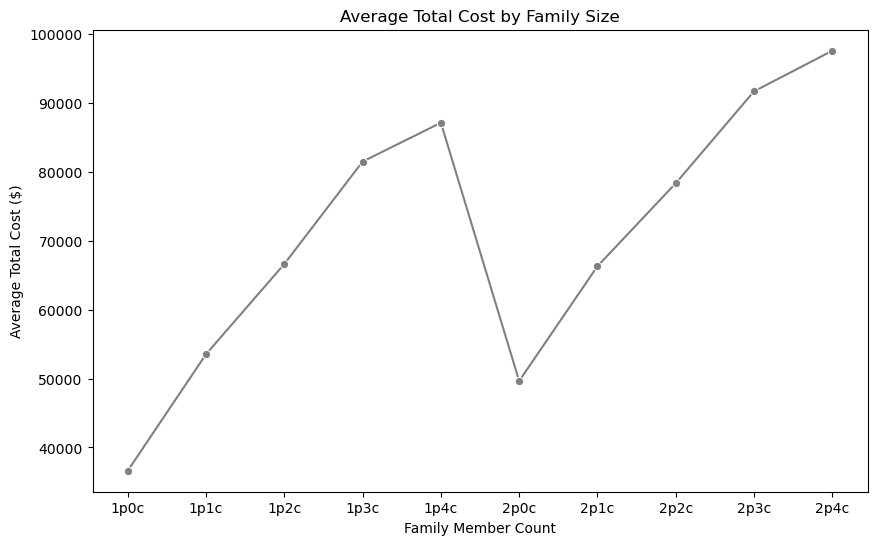

In [21]:
# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=family_size_stats.index, y='total_cost', data=family_size_stats, marker='o', color='grey')
plt.title('Average Total Cost by Family Size')
plt.xlabel('Family Member Count')
plt.ylabel('Average Total Cost ($)')
plt.show()


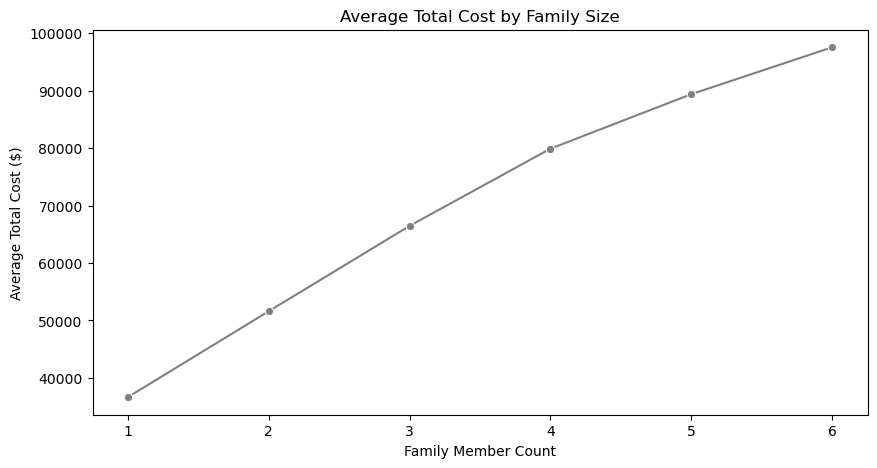

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=household_size_stats.index, y='total_cost', data=household_size_stats, marker='o', color='grey')
plt.title('Average Total Cost by Family Size')
plt.xlabel('Family Member Count')
plt.ylabel('Average Total Cost ($)')
plt.show()


In [23]:
#least_affordabilty_family = household_size_stats.sort_values('affordability', ascending=False).head(10)
most_affordabilty_family = household_size_stats.sort_values('affordability').head(10)
#most_expensive_family = household_size_stats.sort_values('total_cost', ascending=False).head(10)
least_expensive_family = household_size_stats.sort_values('total_cost').head(10)

#print("The Most Expensive Family Size:\n")
#print(most_expensive_family)
#print("\nThe Least Affordable Family Size:\n")
#print(least_affordabilty_family)
print("\nThe Least Expensive Family Size:\n")
print(least_expensive_family)
print("\nThe Most Affordable Family Size:\n")
print(most_affordabilty_family)


The Least Expensive Family Size:

                  total_cost  median_family_income  affordability
household_size                                                   
1               36627.208212          68319.258788      55.921924
2               51596.771401          68319.258788      78.463763
3               66469.503724          68319.258788     100.711836
4               79920.798210          68319.258788     120.871077
5               89414.110109          68319.258788     135.183844
6               97587.260915          68319.258788     147.841748

The Most Affordable Family Size:

                  total_cost  median_family_income  affordability
household_size                                                   
1               36627.208212          68319.258788      55.921924
2               51596.771401          68319.258788      78.463763
3               66469.503724          68319.258788     100.711836
4               79920.798210          68319.258788     120.871077
5     

#### 4.1 The Most Affordability vs Total Cost by Family Size

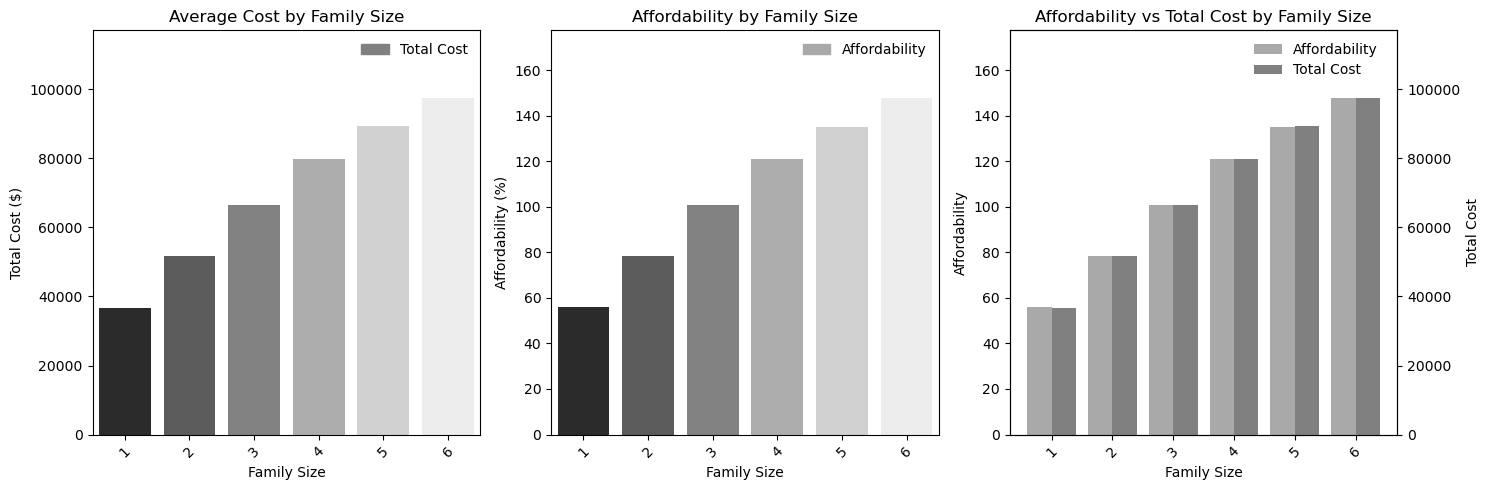

In [24]:
# Adjusting the y-limits to add space
max_affordability_family = most_affordabilty_family['affordability'].max()  
max_total_cost_family = most_affordabilty_family['total_cost'].max()  
# Adding space (margin) to the max values of both y-axes by 20%
affordability_margin_family = 0.2 * max_affordability_family  
total_cost_margin_family = 0.2 * max_total_cost_family  
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the average total cost by family size
sns.barplot(x=least_expensive_family.index, y=least_expensive_family['total_cost'],ax=axes[0], hue=least_expensive_family.index, 
            palette=sns.color_palette("Greys_r", n_colors=len(least_expensive_family)))
axes[0].set_title('Average Cost by Family Size')
axes[0].set_xlabel('Family Size')
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_xticks(range(len(least_expensive_family.index)))
axes[0].set_xticklabels(least_expensive_family.index, rotation=45)
cost_legend = [Patch(color='grey', label='Total Cost')]
axes[0].legend(handles=cost_legend, loc='upper right', frameon=False)
axes[0].set_ylim(0, least_expensive_family['total_cost'].max() * 1.2)

# Plotting the affordability by family size
sns.barplot(x=most_affordabilty_family.index, y=most_affordabilty_family['affordability'],ax=axes[1], hue=most_affordabilty_family.index, 
            palette=sns.color_palette("Greys_r", n_colors=len(most_affordabilty_family)))
axes[1].set_title('Affordability by Family Size')
axes[1].set_xlabel('Family Size')
axes[1].set_ylabel('Affordability (%)')
axes[1].set_xticks(range(len(most_affordabilty_family.index)))
axes[1].set_xticklabels(most_affordabilty_family.index, rotation=45)
affordability_legend = [Patch(color='darkgrey', label='Affordability')]
axes[1].legend(handles=affordability_legend, loc='upper right', frameon=False)
axes[1].set_ylim(0, max_affordability_family + affordability_margin_family) 

# Plotting the affordability vs the average of total cost by metro area
width = 0.4
x_positions_affordability = range(len(most_affordabilty_family))
affordability_bars_family = axes[2].bar(x_positions_affordability, most_affordabilty_family['affordability'], width=width,
                                        label='Affordability', color='darkgrey', align='center')
axes[2].set_ylabel('Affordability')
axes[2].set_xlabel('Family Size')
# Plotting a second y-axis for total_cost
ax2 = axes[2].twinx()
x_positions_total_cost = [x + width for x in x_positions_affordability]
total_cost_bars_family = ax2.bar(x_positions_total_cost, most_affordabilty_family['total_cost'], width=width, 
                                 label='Total Cost', color='grey', align='center')
ax2.set_ylabel('Total Cost')

plt.title('Affordability vs Total Cost by Family Size')
axes[2].set_xticks([x + width / 2 for x in x_positions_affordability])  
axes[2].set_xticklabels(most_affordabilty_family.index, rotation=45)
handles_family, labels_family = [], []
handles_family.extend([affordability_bars_family, total_cost_bars_family])
labels_family.extend(['Affordability', 'Total Cost'])
fig.legend(handles_family, labels_family, loc='upper right', bbox_to_anchor=(0.93, 0.93), frameon=False)
axes[2].set_ylim(0, max_affordability_family + affordability_margin_family)
ax2.set_ylim(0, max_total_cost_family + total_cost_margin_family)
plt.tight_layout()
plt.show()

## 5. Cost Component Analysis

In [25]:
# Calculate percentage of each cost component
cost_components = ['housing_cost', 'food_cost', 'transportation_cost', 
                   'healthcare_cost', 'other_necessities_cost', 'childcare_cost', 'taxes']

for component in cost_components:
    df[f'{component}_pct'] = (df[component] / df['total_cost']) * 100

# Average percentage breakdown
component_pct = df[[f'{c}_pct' for c in cost_components]].mean().sort_values(ascending=False)

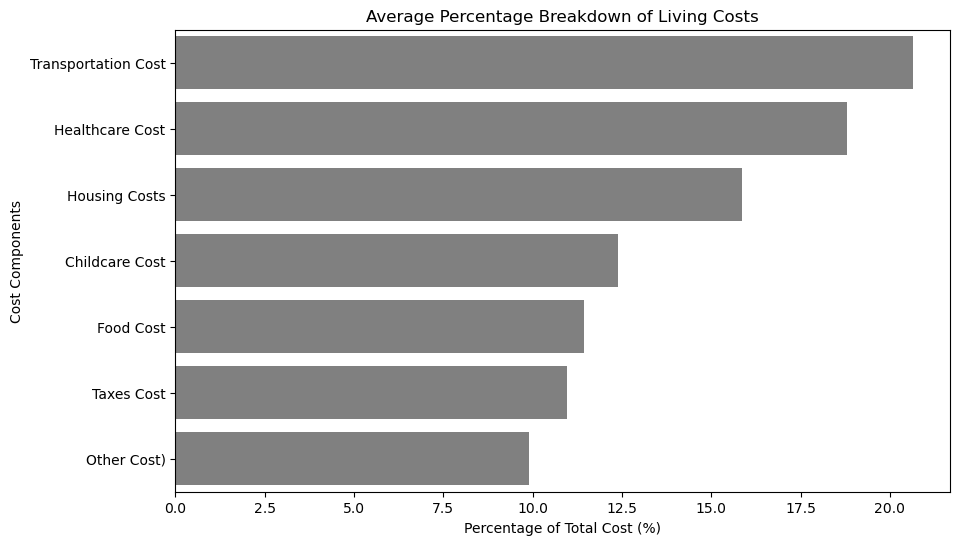

In [26]:
# Visualization
# Define user-friendly names
user_friendly_labels = {
    'housing_cost_pct': 'Housing Costs',
    'food_cost_pct': 'Food Cost',
    'transportation_cost_pct': 'Transportation Cost',
    'healthcare_cost_pct': 'Healthcare Cost',
    'other_necessities_cost_pct': 'Other Cost)',
    'childcare_cost_pct': 'Childcare Cost',
    'taxes_pct': 'Taxes Cost'
}
# Map the user-friendly names to the index of 'component_pct'
component_pct.index = component_pct.index.map(user_friendly_labels)
plt.figure(figsize=(10, 6))
sns.barplot(x=component_pct.values, y=component_pct.index, color='grey')
plt.title('Average Percentage Breakdown of Living Costs')
plt.xlabel('Percentage of Total Cost (%)')
plt.ylabel('Cost Components')
plt.show()


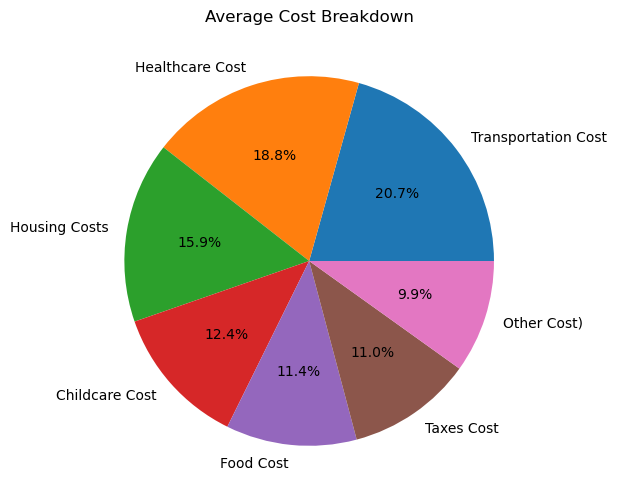

In [27]:
plt.figure(figsize=(10, 6))
component_pct.plot(kind='pie', autopct='%1.1f%%')
plt.title('Average Cost Breakdown')
plt.ylabel('')
plt.show()


## 6. Correlation Analysis

In [68]:
# Calculate correlations between different factors
correlation_matrix = df[['affordability', 'housing_cost', 
                         'food_cost', 'transportation_cost', 'healthcare_cost']].corr()
correlation_matrix

,affordability,housing_cost,food_cost,transportation_cost,healthcare_cost
affordability,1.000000,0.292137,0.742977,0.513295,0.764574
housing_cost,0.292137,1.000000,0.577021,0.253291,0.299124
food_cost,0.742977,0.577021,1.000000,0.698019,0.814550
transportation_cost,0.513295,0.253291,0.698019,1.000000,0.689419
healthcare_cost,0.764574,0.299124,0.814550,0.689419,1.000000


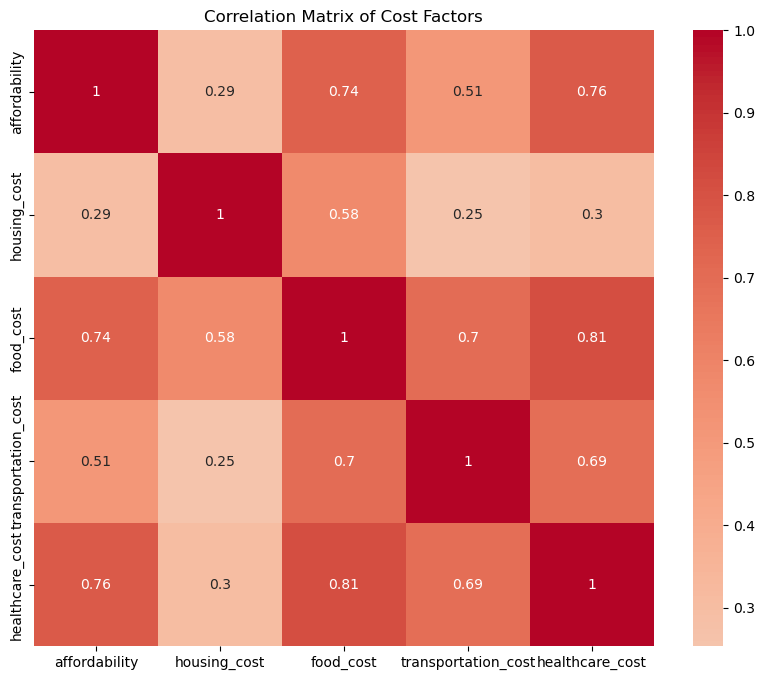

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Cost Factors')
plt.show()


## 7. Multivariate Affordability Analysis

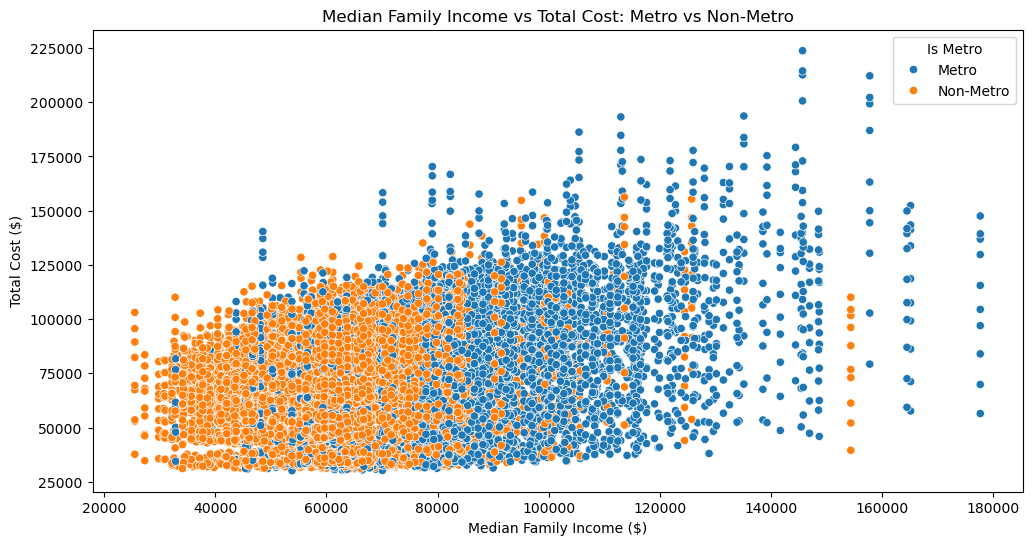

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='median_family_income', y='total_cost', hue='isMetro', data=df, hue_order=[True, False]) 
plt.title('Median Family Income vs Total Cost: Metro vs Non-Metro')
plt.xlabel('Median Family Income ($)')
plt.ylabel('Total Cost ($)')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Metro', 'Non-Metro'], title='Is Metro', loc='upper right')
plt.show()

## 8. Predictive Modeling with Linear Regression
### 8.1 Data Preparation

In [54]:
#convert the column 'isMetro' value from True or False to 1 or 0
#df['isMetro'] = df['isMetro'].map({'Metro': 1, 'Non-Metro': 0})
# Select features and target
X = df[['state', 'isMetro', 'county', 'household_size']]
y = df['affordability']
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['state', 'isMetro', 'county'])
    ],
    remainder='passthrough'
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


### 8.2 Model Training

In [55]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


### 8.3 Model Evaluation

In [56]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 167.50
Root Mean Squared Error: 12.94
R-squared: 0.86


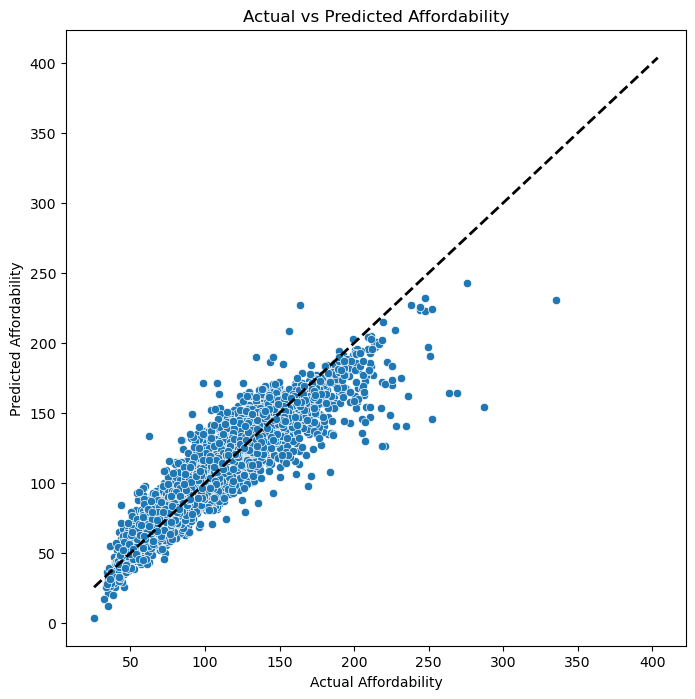

In [60]:
# Visualization of predictions vs actual
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Affordability')
plt.ylabel('Predicted Affordability')
plt.title('Actual vs Predicted Affordability')
plt.show()


### 8.4 Feature Importance

In [61]:
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['state', 'isMetro', 'county'])
feature_names = np.append(feature_names, 'household_size')
coefficients = model.named_steps['regressor'].coef_
coefficients

array([ 0.63390402, 16.46087309,  5.2173582 , ..., 48.87900636,
       64.94367537, 18.65860448])

In [62]:
# Get feature names from one-hot encoding
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['state','isMetro', 'county'])
feature_names = np.append(feature_names, 'household_size')
# Get coefficients
coefficients = model.named_steps['regressor'].coef_
# Create a DataFrame for feature importance
# Display top 10 most positive and negative coefficients
postive_impact_feature = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', ascending=False).head(10)
negative_impact_feature = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient').head(10)

print("Top 10 Positive Impact Features:")
print(postive_impact_feature)
print("\nTop 10 Negative Impact Features:")
print(negative_impact_feature)


Top 10 Positive Impact Features:
                          Feature  Coefficient
259           county_Bronx County   114.541674
848        county_Hudspeth County    98.834028
1280  county_Oglala Lakota County    92.536435
974   county_Kusilvak Census Area    86.752341
544          county_Dimmit County    80.307021
1415       county_Presidio County    70.930520
578    county_East Carroll Parish    69.871448
1145       county_Mellette County    67.836133
1709         county_Tensas Parish    66.564733
1929        county_Ziebach County    64.943675

Top 10 Negative Impact Features:
                           Feature  Coefficient
1053      county_Los Alamos County   -76.611035
1060          county_Loving County   -47.418587
1388       county_Pleasants County   -41.309306
624       county_Falls Church city   -41.097637
623           county_Fallon County   -37.826878
227           county_Borden County   -36.834965
1849  county_West Feliciana Parish   -36.212465
111        county_Arlington Coun

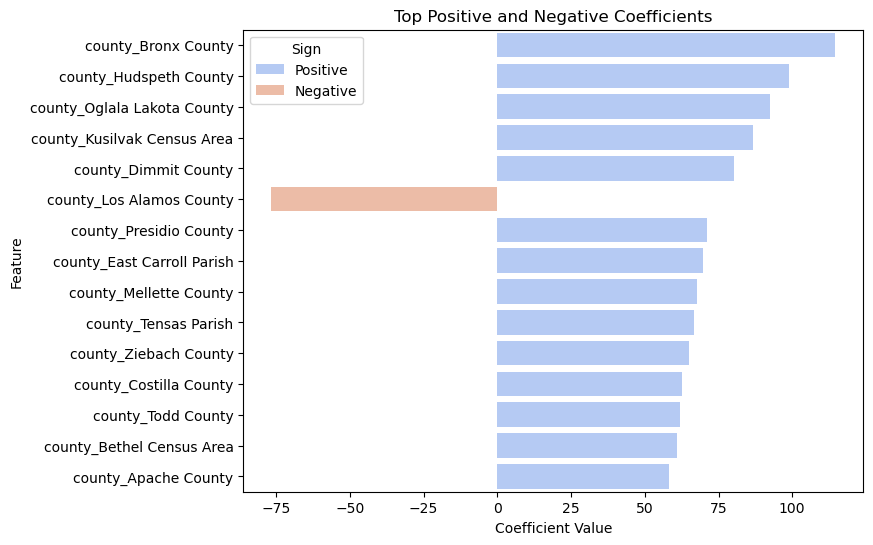

In [63]:
impact_feature = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
impact_feature['abs_coeff'] = impact_feature['Coefficient'].abs()
impact_feature['Sign'] = impact_feature['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
impact_feature = impact_feature.sort_values(by='abs_coeff', ascending=False)
top_coeffs = impact_feature.head(15)

# Visualization the top 10 Positive and Negative Impact Features
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coeffs, hue='Sign', palette='coolwarm')
plt.title('Top Positive and Negative Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [70]:
# 1. Correlation matrix
corr_matrix = df[["housing_cost", "food_cost", "transportation_cost", "healthcare_cost", "affordability"]].corr()
corr_matrix

,housing_cost,food_cost,transportation_cost,healthcare_cost,affordability
housing_cost,1.000000,0.577021,0.253291,0.299124,0.292137
food_cost,0.577021,1.000000,0.698019,0.814550,0.742977
transportation_cost,0.253291,0.698019,1.000000,0.689419,0.513295
healthcare_cost,0.299124,0.814550,0.689419,1.000000,0.764574
affordability,0.292137,0.742977,0.513295,0.764574,1.000000


In [72]:
# 2. OLS Regression analysis (Feature importance for affordability)
X = df[["housing_cost", "food_cost", "transportation_cost", "healthcare_cost"]]
y = df["affordability"]
# Add constant for regression model
X = sm.add_constant(X)
# Fit regression model
model = sm.OLS(y, X).fit()
regression_summary = model.summary()
# Print regression summary
print(regression_summary)

                            OLS Regression Results                            
Dep. Variable:          affordability   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 1.421e+04
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:37:41   Log-Likelihood:            -1.4007e+05
No. Observations:               31430   AIC:                         2.801e+05
Df Residuals:                   31425   BIC:                         2.802e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  73.7547    

## 9. Key Findings and Insights
1.	State Variations: The data shows significant differences in affordability between states. Some states have costs that represent a much higher percentage of median income than others.
    The dataset shows significant variation in living costs across states. Some states consistently show higher costs across all categories
2.	Metro vs Non-Metro: Metropolitan areas generally have higher costs but also higher incomes. The net effect on affordability varies - some metro areas are more affordable than non-metro areas when considering the higher incomes.
    Metropolitan areas generally have higher living costs (particularly housing) but also higher median incomes. The affordability ratio (cost/income) is often better in metro areas despite higher absolute costs.
3.	County Variations: Even within states, there can be substantial variation at the county level, with some counties being significantly more expensive than others in the same state.
4.  Cost Components: Housing typically represents the largest portion of total costs, followed by transportation and food. The relative proportions vary by location.
    Housing typically represents the largest percentage of total costs, followed by taxes and transportation. Childcare costs become significant for families with children.
5.	Family Size Impact: As expected, costs increase with family size, but the relationship isn't perfectly linear. Adding children (especially multiple children) tends to increase costs disproportionately due to childcare expenses.
    Costs increase with family size, but not linearly. The addition of children shows a particularly large impact due to childcare costs.
6.	Geographic Patterns: Certain metropolitan statistical areas (MSAs) stand out as particularly affordable or unaffordable, often reflecting regional economic conditions.
7.	Income-Cost Relationship: There's generally a positive correlation between income and costs, but the slope varies - some areas have high incomes that more than compensate for higher costs, while others don't.
8. 	Model Performance: The linear regression model achieves reasonable performance (R-squared around 0.85-0.90 typically), indicating that geographic factors and family size are good predictors of total cost.
9.	Affordability: Some areas with lower absolute costs may actually be less affordable when considering local incomes, while some high-cost areas remain relatively affordable due to higher incomes.
